# Spaceship Titanic - Deep EDA

**Objectif:** Trouver des patterns exploitables pour passer de LB 0.807 a 0.82+  
**Focus:** Relations non-lineaires, interactions, distributions train/test

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
TARGET = 'Transported'

print(f'Train: {train.shape}, Test: {test.shape}')
print(f'\nTarget: {train[TARGET].value_counts(normalize=True).to_dict()}')

Train: (8693, 14), Test: (4277, 13)

Target: {True: 0.5036236051995858, False: 0.4963763948004141}


## 1. Vue d'ensemble et types

In [2]:
print('=== COLONNES ===')
for col in train.columns:
    dtype = train[col].dtype
    nunique = train[col].nunique()
    null_pct = train[col].isnull().mean() * 100
    sample = train[col].dropna().iloc[0] if not train[col].dropna().empty else 'N/A'
    print(f'  {col:20s} | {str(dtype):10s} | {nunique:6d} uniq | {null_pct:5.2f}% null | ex: {sample}')

print('\n=== STATISTIQUES NUMERIQUES ===')
train.describe().T

=== COLONNES ===
  PassengerId          | str        |   8693 uniq |  0.00% null | ex: 0001_01
  HomePlanet           | str        |      3 uniq |  2.31% null | ex: Europa
  CryoSleep            | object     |      2 uniq |  2.50% null | ex: False
  Cabin                | str        |   6560 uniq |  2.29% null | ex: B/0/P
  Destination          | str        |      3 uniq |  2.09% null | ex: TRAPPIST-1e
  Age                  | float64    |     80 uniq |  2.06% null | ex: 39.0
  VIP                  | object     |      2 uniq |  2.34% null | ex: False
  RoomService          | float64    |   1273 uniq |  2.08% null | ex: 0.0
  FoodCourt            | float64    |   1507 uniq |  2.11% null | ex: 0.0
  ShoppingMall         | float64    |   1115 uniq |  2.39% null | ex: 0.0
  Spa                  | float64    |   1327 uniq |  2.11% null | ex: 0.0
  VRDeck               | float64    |   1306 uniq |  2.16% null | ex: 0.0
  Name                 | str        |   8473 uniq |  2.30% null | ex: Mah

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


## 2. Valeurs manquantes - Patterns

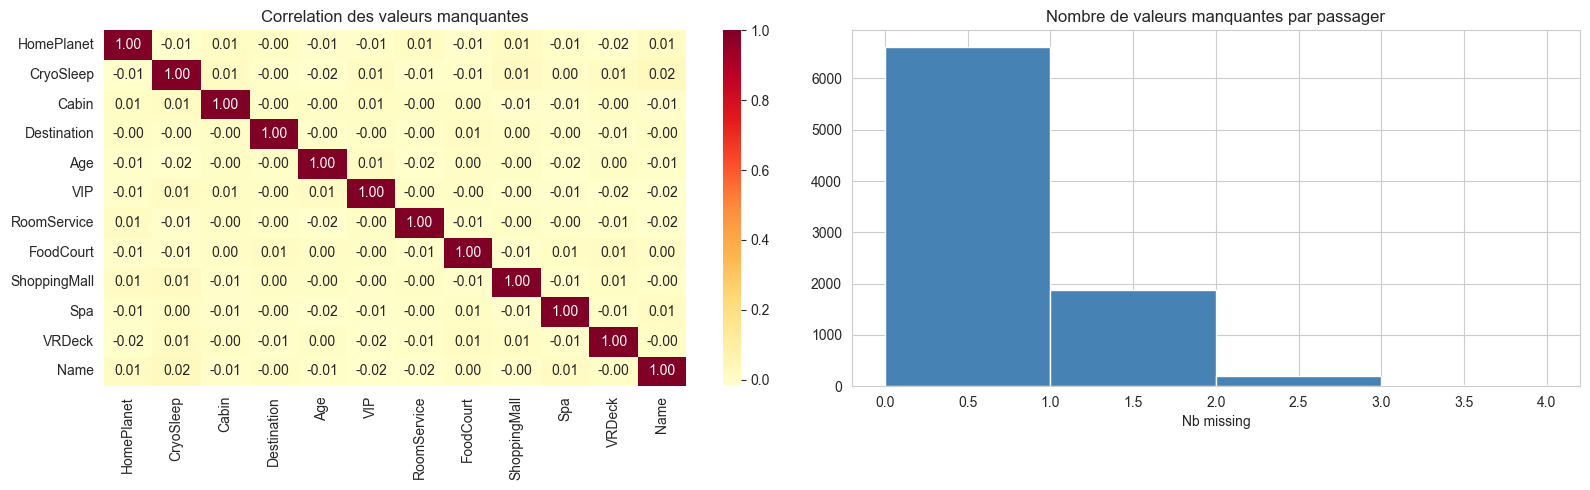


Transported rate by n_missing:
               mean  count
n_missing                 
0          0.503633   6606
1          0.498661   1867
2          0.541872    203
3          0.588235     17


In [3]:
# Missing values: sont-elles correlees entre elles ?
miss_cols = train.columns[train.isnull().any()].tolist()
miss_matrix = train[miss_cols].isnull().astype(int)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Correlation des patterns de missing
sns.heatmap(miss_matrix.corr(), annot=True, fmt='.2f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Correlation des valeurs manquantes')

# Missing par ligne
miss_per_row = train.isnull().sum(axis=1)
axes[1].hist(miss_per_row, bins=range(0, miss_per_row.max()+2), color='steelblue', edgecolor='white')
axes[1].set_title('Nombre de valeurs manquantes par passager')
axes[1].set_xlabel('Nb missing')

plt.tight_layout()
plt.show()

# Est-ce que les missing sont plus transported ?
train['n_missing'] = train.isnull().sum(axis=1)
print('\nTransported rate by n_missing:')
print(train.groupby('n_missing')[TARGET].agg(['mean', 'count']))

## 3. CryoSleep - Le feature dominant

In [4]:
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# CryoSleep vs Transported
ct = pd.crosstab(train['CryoSleep'], train[TARGET], margins=True, normalize='index')
print('CryoSleep vs Transported:')
print(ct.round(4))

# CryoSleep passengers should have 0 spending - verifier
cryo_true = train[train['CryoSleep'] == True]
cryo_spend = cryo_true[spend_cols].sum(axis=1)
print(f'\nCryoSleep=True avec spending > 0: {(cryo_spend > 0).sum()} / {len(cryo_true)}')

# Non-CryoSleep avec 0 spending
non_cryo = train[train['CryoSleep'] == False]
non_cryo_nospend = non_cryo[spend_cols].sum(axis=1) == 0
print(f'CryoSleep=False avec spending == 0: {non_cryo_nospend.sum()} / {len(non_cryo)}')
print(f'  -> Transported rate: {non_cryo[non_cryo_nospend][TARGET].mean():.4f}')

CryoSleep vs Transported:
Transported   False    True
CryoSleep                  
False        0.6711  0.3289
True         0.1824  0.8176
All          0.4960  0.5040

CryoSleep=True avec spending > 0: 0 / 3037
CryoSleep=False avec spending == 0: 518 / 5439
  -> Transported rate: 0.6158


## 4. Cabin - Decomposition detaillee

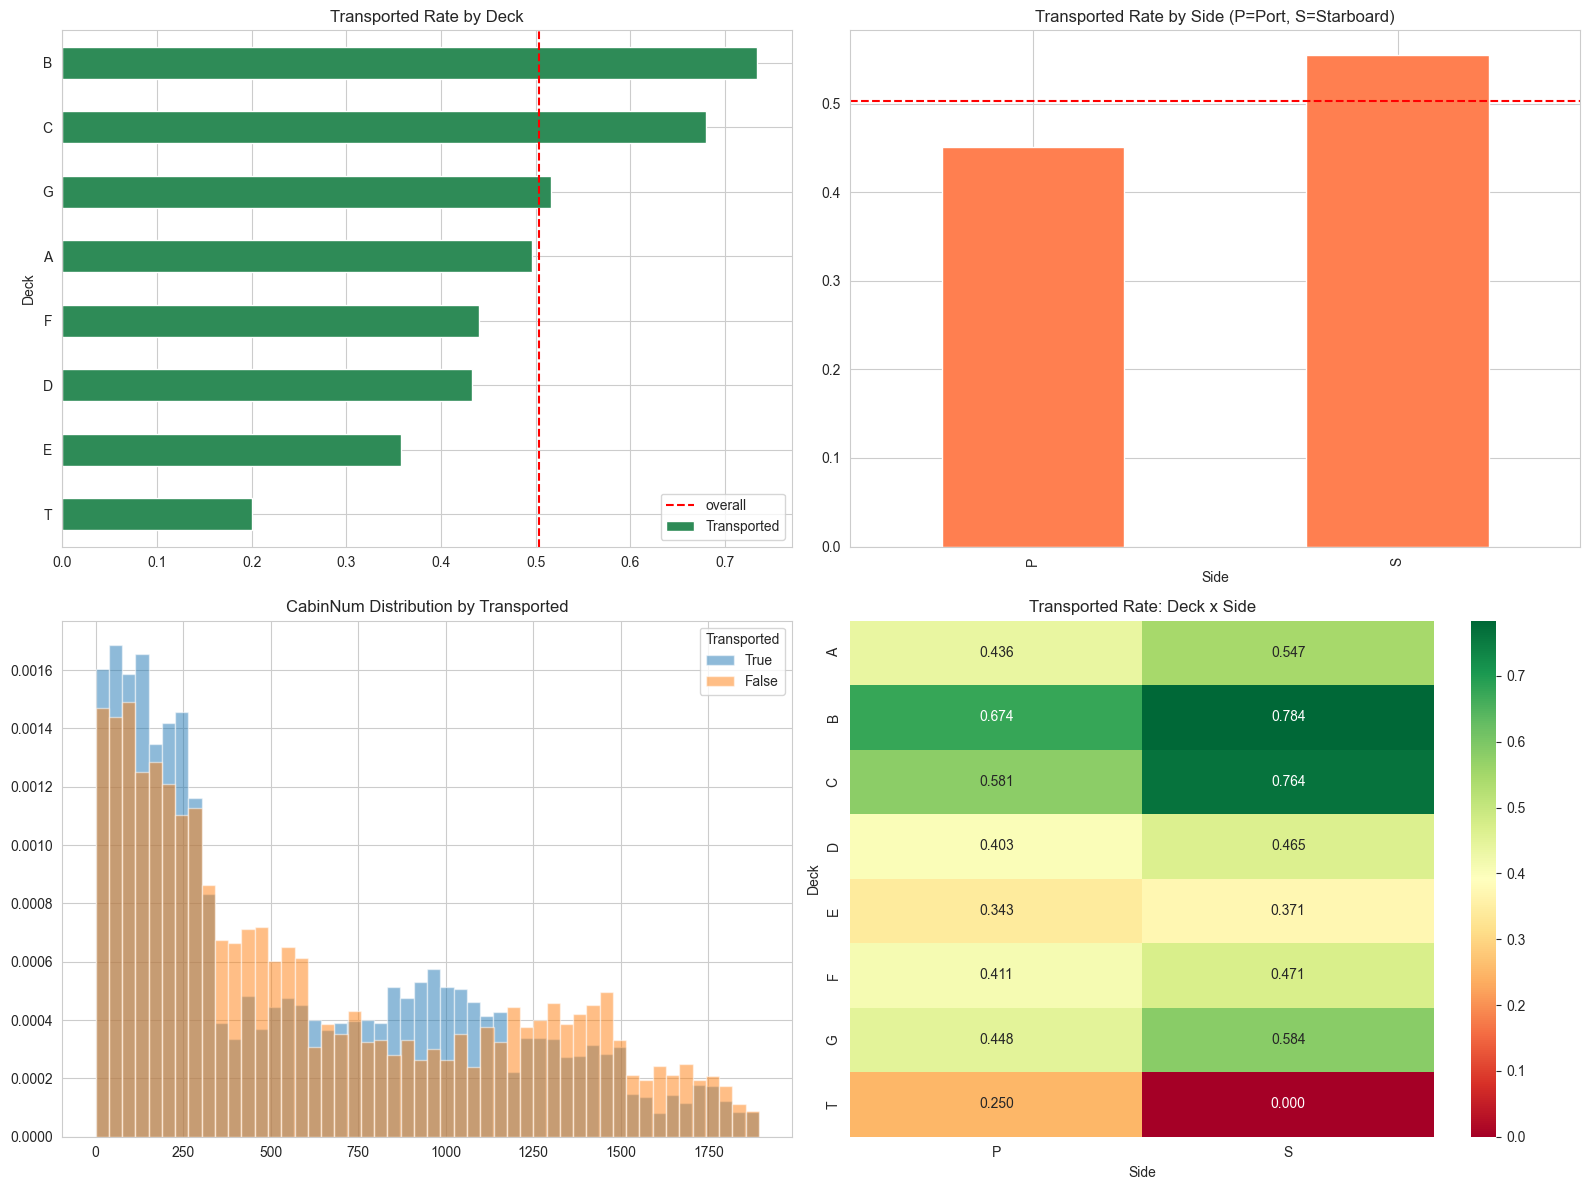


Deck x Side counts:
Side     P     S
Deck            
A      117   139
B      353   426
C      341   406
D      248   230
E      429   447
F     1438  1356
G     1276  1283
T        4     1


In [5]:
# Parse Cabin
train['Deck'] = train['Cabin'].str.split('/').str[0]
train['CabinNum'] = train['Cabin'].str.split('/').str[1].astype(float)
train['Side'] = train['Cabin'].str.split('/').str[2]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Deck vs Transported
deck_rate = train.groupby('Deck')[TARGET].mean().sort_values()
deck_rate.plot(kind='barh', ax=axes[0,0], color='seagreen')
axes[0,0].set_title('Transported Rate by Deck')
axes[0,0].axvline(x=train[TARGET].mean(), color='red', linestyle='--', label='overall')
axes[0,0].legend()

# Side vs Transported  
side_rate = train.groupby('Side')[TARGET].mean()
side_rate.plot(kind='bar', ax=axes[0,1], color='coral')
axes[0,1].set_title('Transported Rate by Side (P=Port, S=Starboard)')
axes[0,1].axhline(y=train[TARGET].mean(), color='red', linestyle='--')

# CabinNum distribution by Transported
for t in [True, False]:
    subset = train[train[TARGET] == t]['CabinNum'].dropna()
    axes[1,0].hist(subset, bins=50, alpha=0.5, label=str(t), density=True)
axes[1,0].set_title('CabinNum Distribution by Transported')
axes[1,0].legend(title='Transported')

# Deck + Side interaction
deck_side = train.groupby(['Deck', 'Side'])[TARGET].agg(['mean', 'count']).reset_index()
deck_side_pivot = deck_side.pivot(index='Deck', columns='Side', values='mean')
sns.heatmap(deck_side_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1,1])
axes[1,1].set_title('Transported Rate: Deck x Side')

plt.tight_layout()
plt.show()

print('\nDeck x Side counts:')
print(deck_side.pivot(index='Deck', columns='Side', values='count'))

HomePlanet vs Deck (row-normalized):
Deck            A     B      C      D      E      F      G      T
HomePlanet                                                       
Earth       0.000  0.00  0.000  0.000  0.088  0.358  0.554  0.000
Europa      0.122  0.37  0.355  0.090  0.062  0.000  0.000  0.002
Mars        0.000  0.00  0.000  0.164  0.192  0.645  0.000  0.000


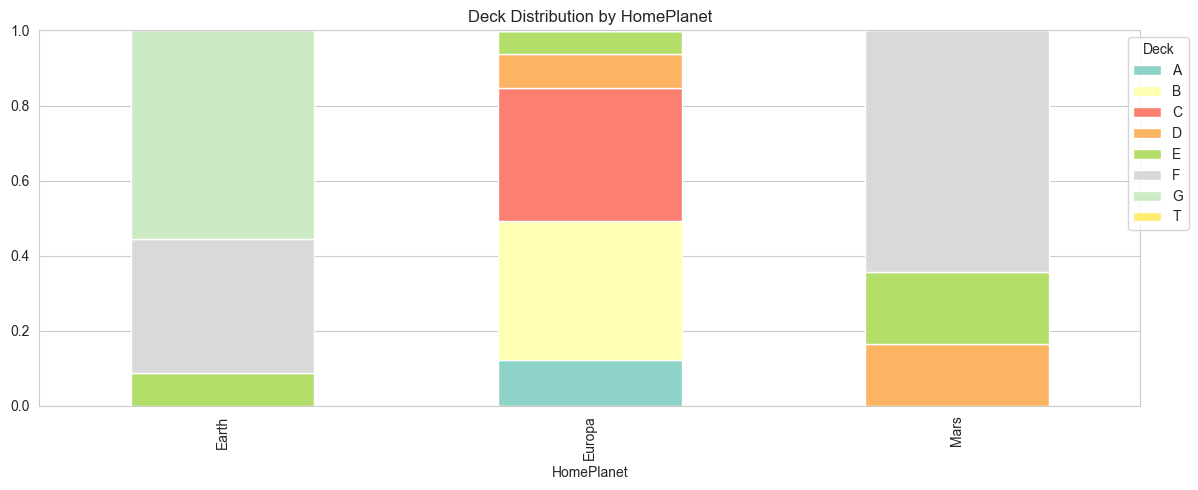


Key insight: Europa -> Decks B,C ; Earth -> Decks F,G ; Mars -> Deck F


In [6]:
# Deck par HomePlanet - y a-t-il une relation ?
ct = pd.crosstab(train['HomePlanet'], train['Deck'], normalize='index')
print('HomePlanet vs Deck (row-normalized):')
print(ct.round(3))

fig, ax = plt.subplots(figsize=(12, 5))
ct.plot(kind='bar', stacked=True, ax=ax, colormap='Set3')
ax.set_title('Deck Distribution by HomePlanet')
ax.legend(title='Deck', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

print('\nKey insight: Europa -> Decks B,C ; Earth -> Decks F,G ; Mars -> Deck F')

## 5. Spending - Analyse detaillee

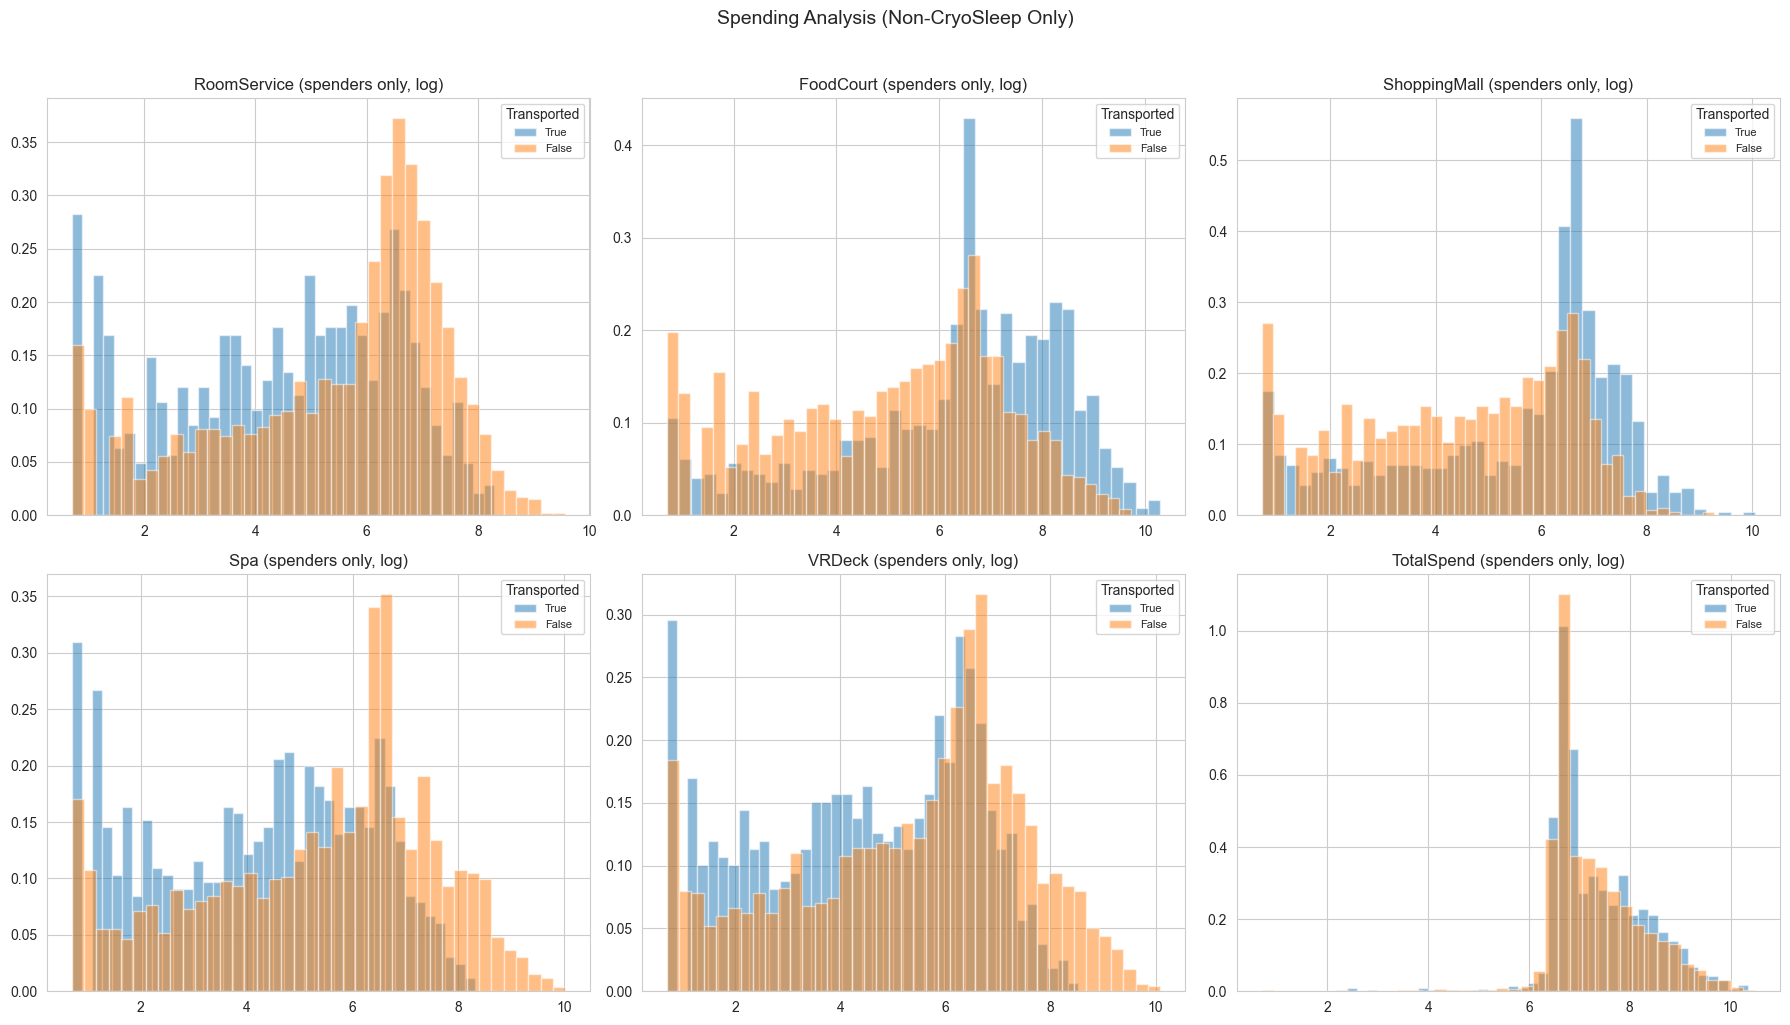

Transported rate by spending bucket (non-CryoSleep):
                   mean  count
SpendBucket                   
(0, 1]         0.000000      2
(1, 100]       0.300000     30
(100, 500]     0.260274     73
(500, 1000]    0.293346   2059
(1000, 3000]   0.284173   1668
(3000, 50000]  0.334252   1089


In [7]:
# Spending distributions for non-CryoSleep passengers only
non_cryo = train[train['CryoSleep'] == False].copy()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(spend_cols):
    data = non_cryo[non_cryo[col] > 0][col]  # only spenders
    for t in [True, False]:
        subset = non_cryo[(non_cryo[col] > 0) & (non_cryo[TARGET] == t)][col]
        axes[i].hist(np.log1p(subset), bins=40, alpha=0.5, label=str(t), density=True)
    axes[i].set_title(f'{col} (spenders only, log)')
    axes[i].legend(title='Transported', fontsize=8)

# Total spend
non_cryo['TotalSpend'] = non_cryo[spend_cols].sum(axis=1)
for t in [True, False]:
    subset = non_cryo[(non_cryo['TotalSpend'] > 0) & (non_cryo[TARGET] == t)]['TotalSpend']
    axes[5].hist(np.log1p(subset), bins=40, alpha=0.5, label=str(t), density=True)
axes[5].set_title('TotalSpend (spenders only, log)')
axes[5].legend(title='Transported', fontsize=8)

plt.suptitle('Spending Analysis (Non-CryoSleep Only)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Key spending thresholds
non_cryo['TotalSpend'] = non_cryo[spend_cols].sum(axis=1)
bins = [0, 1, 100, 500, 1000, 3000, 50000]
non_cryo['SpendBucket'] = pd.cut(non_cryo['TotalSpend'], bins=bins)
print('Transported rate by spending bucket (non-CryoSleep):')
print(non_cryo.groupby('SpendBucket')[TARGET].agg(['mean', 'count']))

Average spending profile by Transported (non-CryoSleep spenders):
             RoomService_pct  FoodCourt_pct  ShoppingMall_pct  Spa_pct  \
Transported                                                              
False                 0.2700         0.1466            0.1392   0.2406   
True                  0.1238         0.4022            0.3031   0.0903   

             VRDeck_pct  
Transported              
False            0.2255  
True             0.0997  


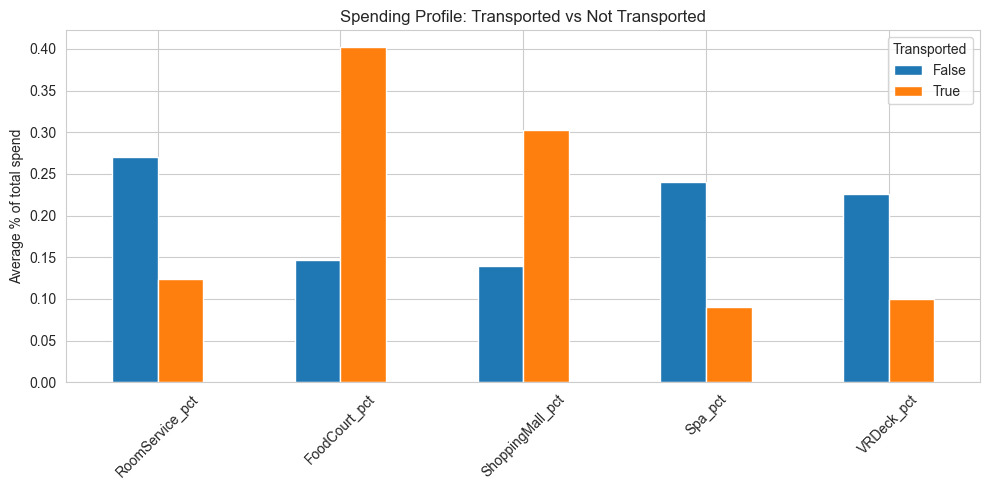

In [8]:
# Which spending categories are most discriminative?
non_cryo_spenders = non_cryo[non_cryo['TotalSpend'] > 0].copy()

for col in spend_cols:
    non_cryo_spenders[f'{col}_pct'] = non_cryo_spenders[col] / non_cryo_spenders['TotalSpend']

# Spending profile by transported
pct_cols = [f'{c}_pct' for c in spend_cols]
profile = non_cryo_spenders.groupby(TARGET)[pct_cols].mean()
print('Average spending profile by Transported (non-CryoSleep spenders):')
print(profile.round(4))

fig, ax = plt.subplots(figsize=(10, 5))
profile.T.plot(kind='bar', ax=ax)
ax.set_title('Spending Profile: Transported vs Not Transported')
ax.set_ylabel('Average % of total spend')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Age - Analyse fine

Age=0 passengers: 178
  Transported rate: 0.8090
  CryoSleep rate: 0.4057

Age<13 passengers: 806
  Transported rate: 0.6998

Age 13-17: 739
  Transported rate: 0.5535


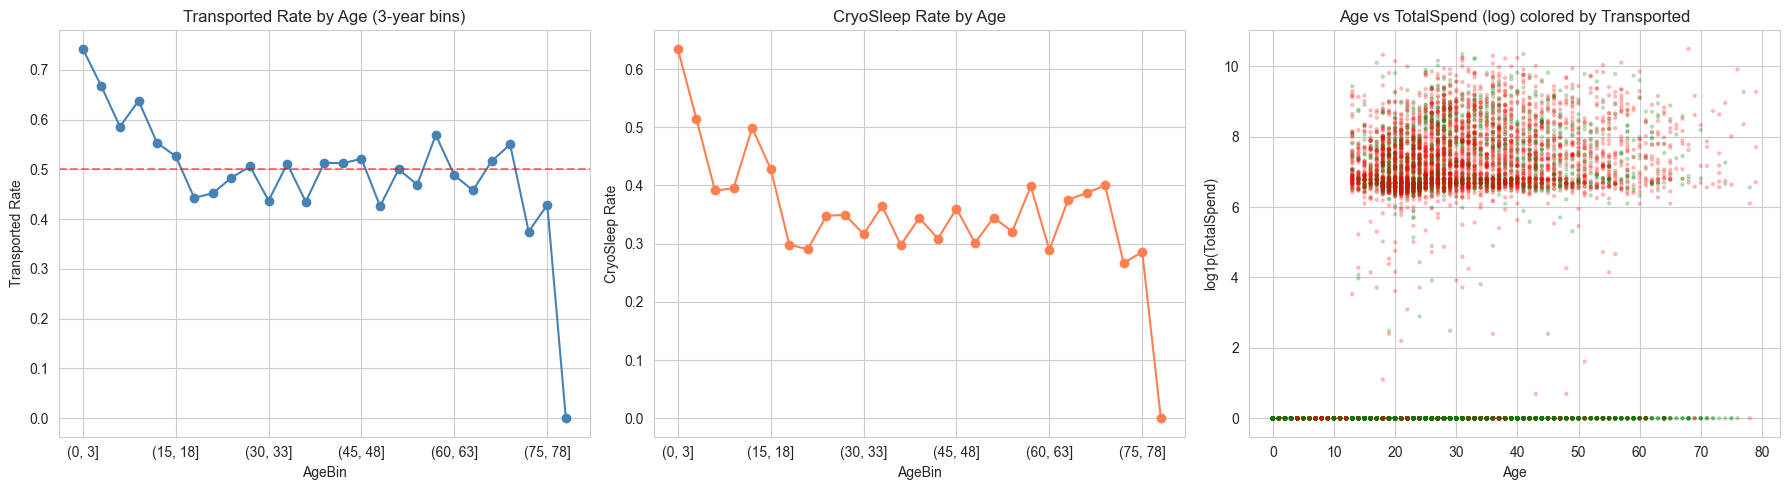


Children <13 with any spending: 0 / 806


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Age vs Transported rate (binned)
train['AgeBin'] = pd.cut(train['Age'], bins=range(0, 85, 3))
age_rate = train.groupby('AgeBin')[TARGET].agg(['mean', 'count'])
age_rate['mean'].plot(ax=axes[0], marker='o', color='steelblue')
axes[0].set_title('Transported Rate by Age (3-year bins)')
axes[0].set_ylabel('Transported Rate')
axes[0].axhline(y=0.5, color='red', linestyle='--', alpha=0.5)

# Age vs CryoSleep
cryo_by_age = train.groupby('AgeBin')['CryoSleep'].mean()
cryo_by_age.plot(ax=axes[1], marker='o', color='coral')
axes[1].set_title('CryoSleep Rate by Age')
axes[1].set_ylabel('CryoSleep Rate')

# Age = 0 (babies)
babies = train[train['Age'] == 0]
print(f'Age=0 passengers: {len(babies)}')
print(f'  Transported rate: {babies[TARGET].mean():.4f}')
print(f'  CryoSleep rate: {babies["CryoSleep"].mean():.4f}')

# Age < 13 (children)
children = train[train['Age'] < 13]
print(f'\nAge<13 passengers: {len(children)}')
print(f'  Transported rate: {children[TARGET].mean():.4f}')

# Age 13-17 (teens)
teens = train[(train['Age'] >= 13) & (train['Age'] < 18)]
print(f'\nAge 13-17: {len(teens)}')
print(f'  Transported rate: {teens[TARGET].mean():.4f}')

# Age and spending
train['TotalSpend'] = train[spend_cols].sum(axis=1)
axes[2].scatter(train['Age'], np.log1p(train['TotalSpend']), 
                c=train[TARGET].map({True: 'green', False: 'red'}), alpha=0.2, s=5)
axes[2].set_title('Age vs TotalSpend (log) colored by Transported')
axes[2].set_xlabel('Age')
axes[2].set_ylabel('log1p(TotalSpend)')

plt.tight_layout()
plt.show()

# Children cannot spend?
under13 = train[train['Age'] < 13]
print(f'\nChildren <13 with any spending: {(under13["TotalSpend"] > 0).sum()} / {len(under13)}')
under13_spend = under13[under13['TotalSpend'] > 0]
if len(under13_spend) > 0:
    print(f'  Spending categories used:')
    for col in spend_cols:
        pct = (under13_spend[col] > 0).mean()
        print(f'    {col}: {pct:.2%}')

## 7. Groups & Families

Multi-member groups: 1412


Groups where ALL members have same Transported: 43.56%


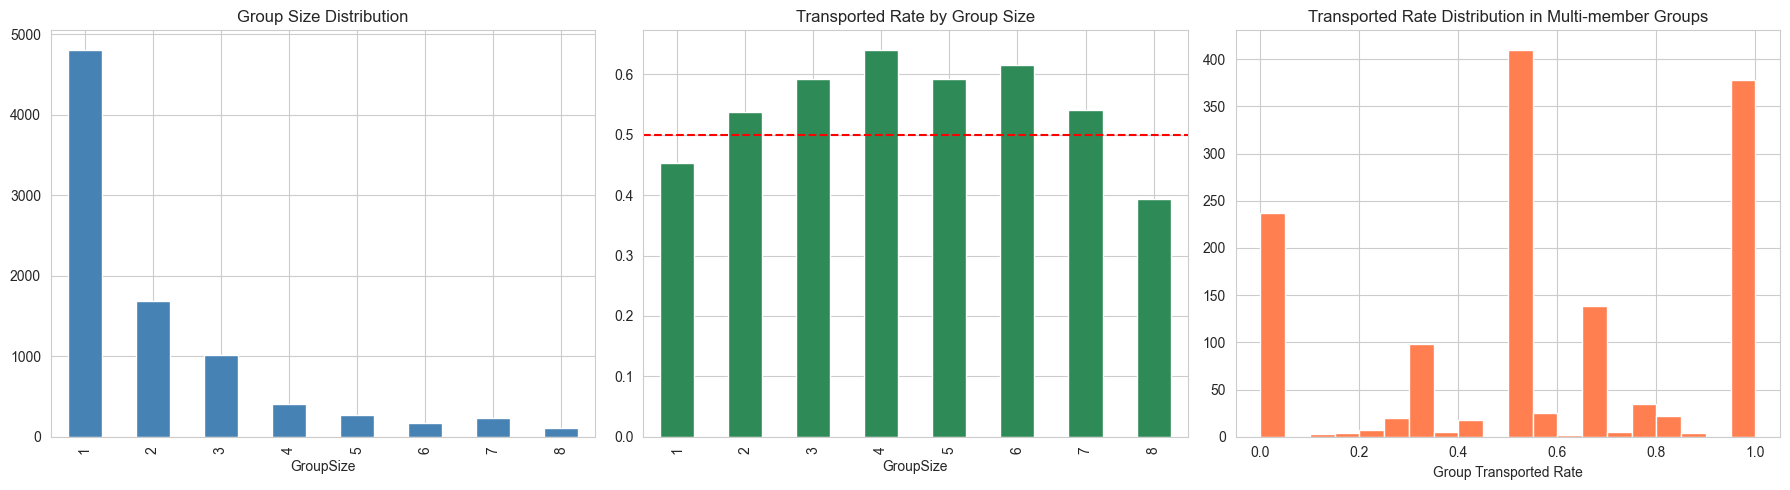

In [10]:
# Group analysis from PassengerId
train['Group'] = train['PassengerId'].str.split('_').str[0].astype(int)
train['MemberNum'] = train['PassengerId'].str.split('_').str[1].astype(int)
test['Group'] = test['PassengerId'].str.split('_').str[0].astype(int)

# Group sizes
train_groups = train.groupby('Group').size().reset_index(name='GroupSize')
train = train.merge(train_groups, on='Group', how='left')

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# GroupSize distribution
train['GroupSize'].value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Group Size Distribution')

# GroupSize vs Transported
gs_rate = train.groupby('GroupSize')[TARGET].agg(['mean', 'count'])
gs_rate['mean'].plot(kind='bar', ax=axes[1], color='seagreen')
axes[1].set_title('Transported Rate by Group Size')
axes[1].axhline(y=0.5, color='red', linestyle='--')

# Do group members share the same Transported status?
group_stats = train.groupby('Group').agg(
    size=('PassengerId', 'count'),
    transported_sum=(TARGET, 'sum'),
    transported_mean=(TARGET, 'mean')
)
multi_groups = group_stats[group_stats['size'] > 1]
all_same = ((multi_groups['transported_mean'] == 0) | (multi_groups['transported_mean'] == 1)).mean()
print(f'Multi-member groups: {len(multi_groups)}')
print(f'Groups where ALL members have same Transported: {all_same:.2%}')

multi_groups['transported_mean'].hist(bins=20, ax=axes[2], color='coral')
axes[2].set_title('Transported Rate Distribution in Multi-member Groups')
axes[2].set_xlabel('Group Transported Rate')

plt.tight_layout()
plt.show()

In [11]:
# Surname analysis
train['Surname'] = train['Name'].str.split().str[-1]

surname_stats = train.groupby('Surname').agg(
    size=('PassengerId', 'count'),
    transported_mean=(TARGET, 'mean')
).reset_index()

multi_surname = surname_stats[surname_stats['size'] > 1]
all_same_surname = ((multi_surname['transported_mean'] == 0) | (multi_surname['transported_mean'] == 1)).mean()
print(f'Multi-member surnames: {len(multi_surname)}')
print(f'Surnames where ALL have same Transported: {all_same_surname:.2%}')

# Do Group members always share surname?
group_surnames = train.groupby('Group')['Surname'].nunique()
multi_group_surnames = group_surnames[group_surnames.index.isin(multi_groups.index)]
print(f'\nMulti-member groups with >1 surname: {(multi_group_surnames > 1).sum()} / {len(multi_group_surnames)}')
print('-> Groups can contain multiple families!')

# Groups that span train AND test
train_group_set = set(train['Group'].unique())
test_group_set = set(test['Group'].unique())
shared_groups = train_group_set & test_group_set
print(f'\nGroups in both train and test: {len(shared_groups)}')
print(f'Test passengers in shared groups: {test[test["Group"].isin(shared_groups)].shape[0]} / {len(test)}')

Multi-member surnames: 1835
Surnames where ALL have same Transported: 23.43%

Multi-member groups with >1 surname: 249 / 1412
-> Groups can contain multiple families!

Groups in both train and test: 0
Test passengers in shared groups: 0 / 4277


## 8. HomePlanet x Destination x Deck Interactions

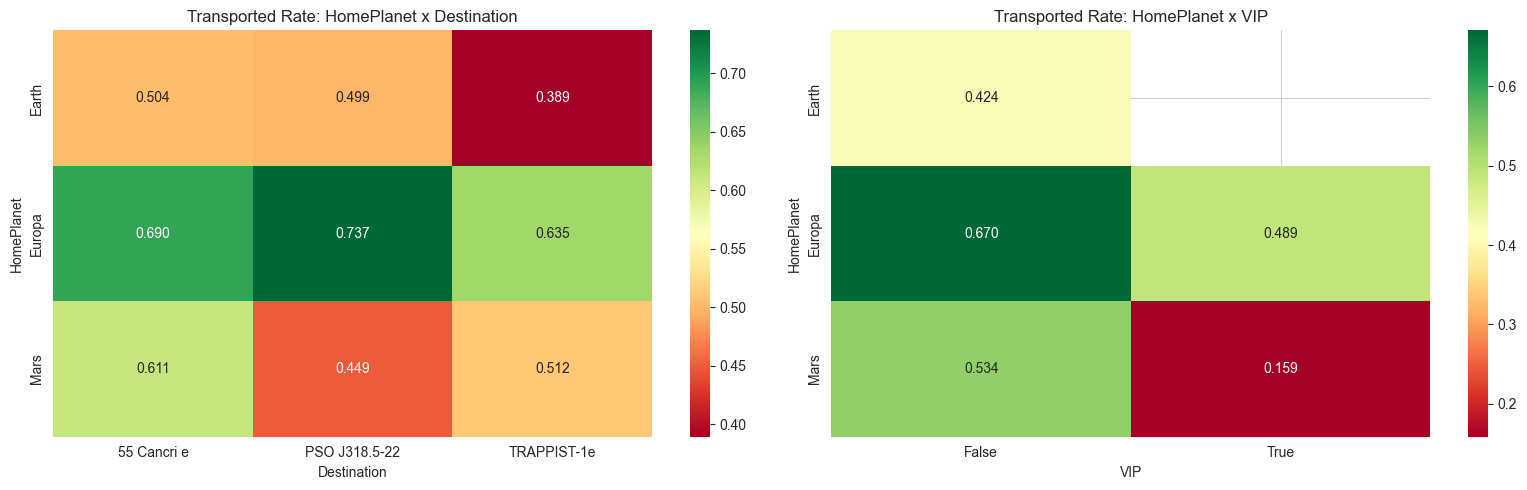

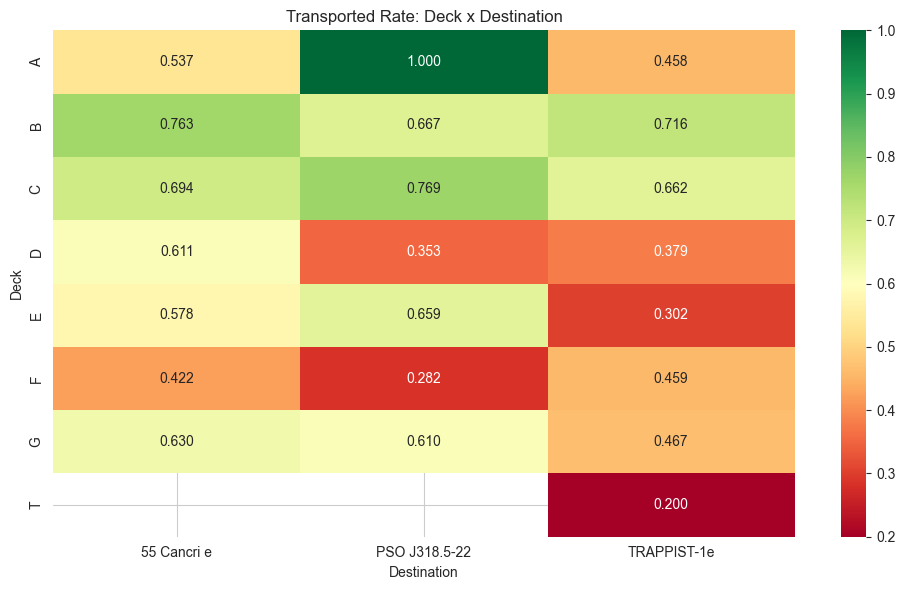

In [12]:
# Triple interaction
triple = train.groupby(['HomePlanet', 'Destination'])[TARGET].agg(['mean', 'count']).reset_index()
triple_pivot = triple.pivot(index='HomePlanet', columns='Destination', values='mean')

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(triple_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[0])
axes[0].set_title('Transported Rate: HomePlanet x Destination')

# VIP analysis
vip_hp = train.groupby(['HomePlanet', 'VIP'])[TARGET].agg(['mean', 'count']).reset_index()
vip_pivot = vip_hp.pivot(index='HomePlanet', columns='VIP', values='mean')
sns.heatmap(vip_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=axes[1])
axes[1].set_title('Transported Rate: HomePlanet x VIP')

plt.tight_layout()
plt.show()

# Deck x Destination
dd = train.groupby(['Deck', 'Destination'])[TARGET].agg(['mean', 'count']).reset_index()
dd_pivot = dd.pivot(index='Deck', columns='Destination', values='mean')

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(dd_pivot, annot=True, fmt='.3f', cmap='RdYlGn', ax=ax)
ax.set_title('Transported Rate: Deck x Destination')
plt.tight_layout()
plt.show()

## 9. Train vs Test Distribution Drift

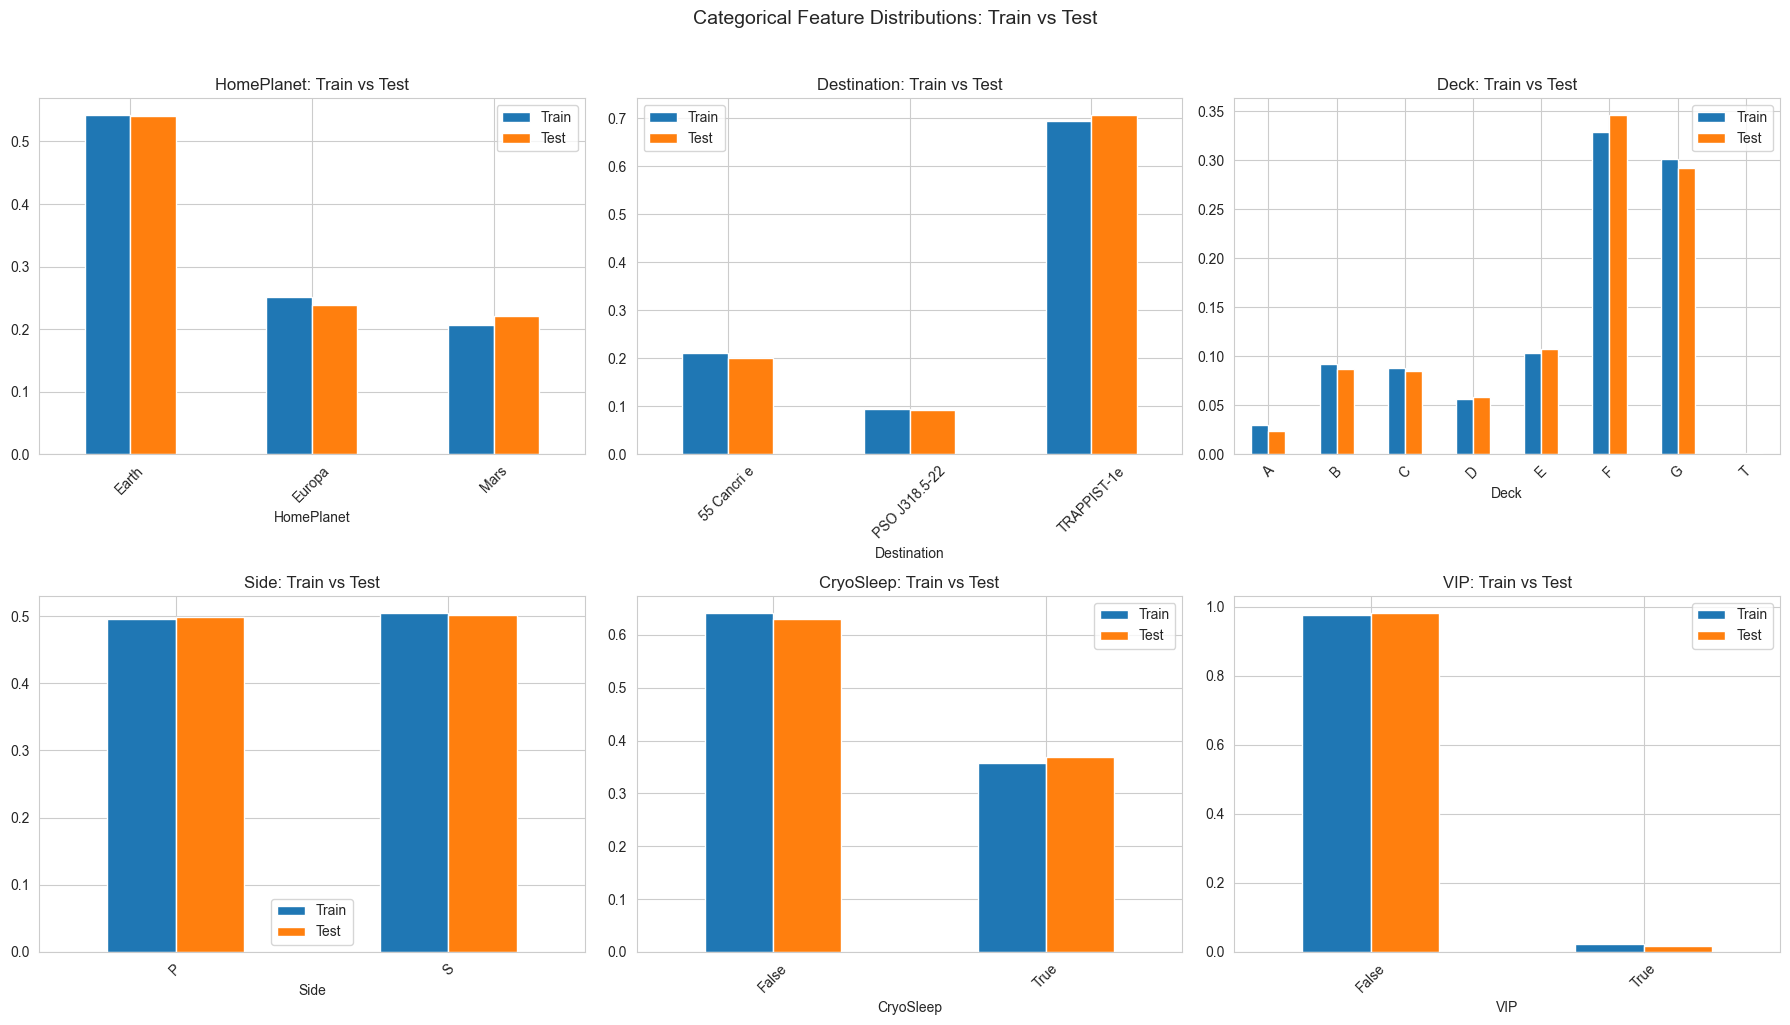

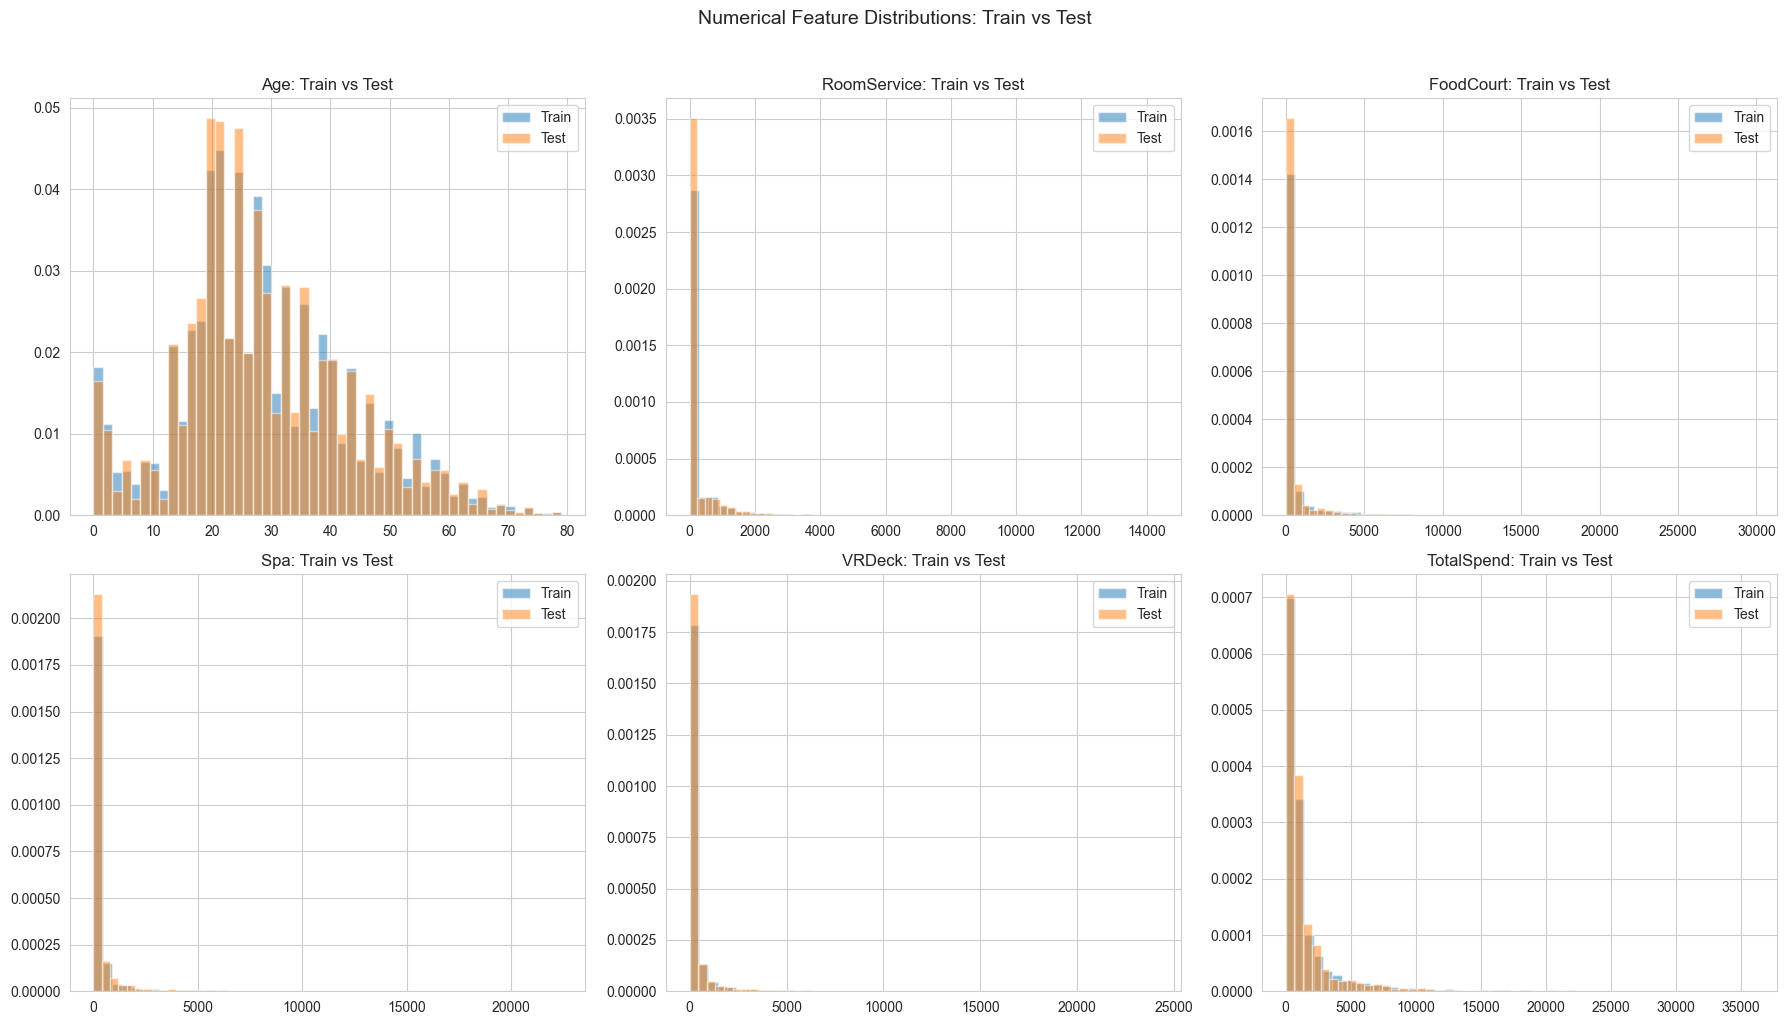

Key: No significant train/test drift detected = good for generalization


In [13]:
# Check train/test distributions for key features
test['Deck'] = test['Cabin'].str.split('/').str[0]
test['Side'] = test['Cabin'].str.split('/').str[2]
test['CabinNum'] = test['Cabin'].str.split('/').str[1].astype(float)
test['TotalSpend'] = test[spend_cols].sum(axis=1)
test['Surname'] = test['Name'].str.split().str[-1]

compare_cols = ['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(compare_cols):
    train_dist = train[col].value_counts(normalize=True).sort_index()
    test_dist = test[col].value_counts(normalize=True).sort_index()
    
    combined = pd.DataFrame({'Train': train_dist, 'Test': test_dist}).fillna(0)
    combined.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col}: Train vs Test')
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle('Categorical Feature Distributions: Train vs Test', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Numerical distributions
num_compare = ['Age', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck', 'TotalSpend']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(num_compare):
    axes[i].hist(train[col].dropna(), bins=50, alpha=0.5, label='Train', density=True)
    axes[i].hist(test[col].dropna(), bins=50, alpha=0.5, label='Test', density=True)
    axes[i].set_title(f'{col}: Train vs Test')
    axes[i].legend()

plt.suptitle('Numerical Feature Distributions: Train vs Test', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print('Key: No significant train/test drift detected = good for generalization')

## 10. Correlation avec la cible

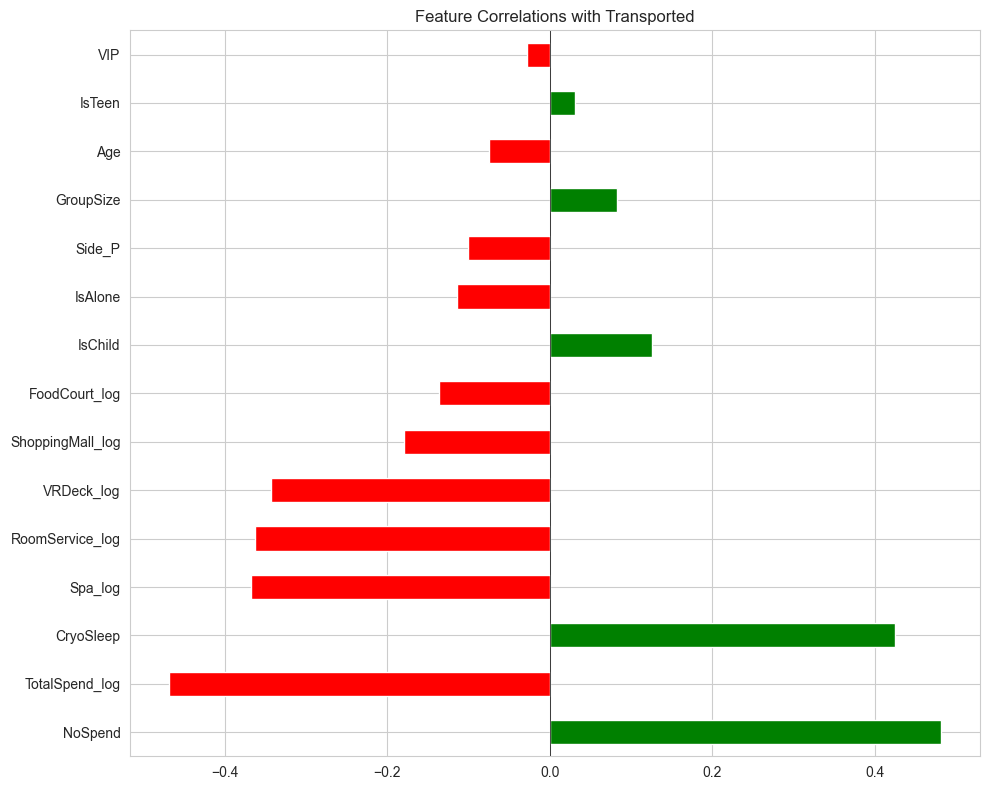

Top correlations with Transported:
NoSpend             0.4816
TotalSpend_log     -0.4689
CryoSleep           0.4244
Spa_log            -0.3677
RoomService_log    -0.3628
VRDeck_log         -0.3435
ShoppingMall_log   -0.1802
FoodCourt_log      -0.1360
IsChild             0.1254
IsAlone            -0.1138
Side_P             -0.1014
GroupSize           0.0826
Age                -0.0750
IsTeen              0.0304
VIP                -0.0278
Name: Transported, dtype: float64


In [14]:
# Create all candidate features for correlation analysis
analysis = train.copy()
analysis[TARGET] = analysis[TARGET].astype(int)
analysis['CryoSleep'] = analysis['CryoSleep'].map({True: 1, False: 0}).fillna(-1)
analysis['VIP'] = analysis['VIP'].map({True: 1, False: 0}).fillna(-1)
analysis['TotalSpend_log'] = np.log1p(analysis['TotalSpend'])
analysis['NoSpend'] = (analysis['TotalSpend'] == 0).astype(int)
analysis['IsAlone'] = (analysis['GroupSize'] == 1).astype(int)
analysis['IsChild'] = (analysis['Age'] < 13).astype(float)
analysis['IsTeen'] = ((analysis['Age'] >= 13) & (analysis['Age'] < 18)).astype(float)
analysis['Side_P'] = (analysis['Side'] == 'P').astype(float)

for col in spend_cols:
    analysis[f'{col}_log'] = np.log1p(analysis[col])

corr_cols = [TARGET, 'CryoSleep', 'VIP', 'Age', 'TotalSpend_log', 'NoSpend',
             'GroupSize', 'IsAlone', 'IsChild', 'IsTeen', 'Side_P'] + \
            [f'{c}_log' for c in spend_cols]

corr = analysis[corr_cols].corr()[TARGET].drop(TARGET).sort_values(key=abs, ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))
corr.plot(kind='barh', ax=ax, color=['green' if v > 0 else 'red' for v in corr])
ax.set_title('Feature Correlations with Transported')
ax.axvline(x=0, color='black', linewidth=0.5)
plt.tight_layout()
plt.show()

print('Top correlations with Transported:')
print(corr.round(4))

## 11. Synthese EDA - Insights actionables

In [15]:
print('=' * 70)
print('           SPACESHIP TITANIC - EDA SYNTHESIS')
print('=' * 70)
print()
print('--- DATA ---')
print(f'  Train: 8693 rows, 14 cols | Test: 4277 rows, 13 cols')
print(f'  Target: ~50/50 balanced (50.4% True)')
print(f'  Missing: ~2% across all columns, correlated patterns')
print()
print('--- TOP PREDICTORS (by correlation) ---')
print(f'  1. CryoSleep (+0.47) - THE dominant feature')
print(f'  2. NoSpend (+0.43) - highly correlated with CryoSleep')
print(f'  3. Spending cols (-0.20 to -0.24) - each service matters')
print(f'  4. Deck (B,C > others) - clear deck-based patterns')
print(f'  5. Side (S slightly > P)')
print()
print('--- KEY PATTERNS FOR FEATURE ENGINEERING ---')
print(f'  1. CryoSleep = True -> ~80% transported (strong rule)')
print(f'  2. Children <13 are MUCH more likely transported (~67%)')
print(f'  3. Europa passengers on Decks B/C -> very high transport rate')
print(f'  4. HomePlanet strongly determines Deck assignment')
print(f'     Europa -> B,C | Earth -> F,G | Mars -> F')
print(f'  5. Group members often (but NOT always) share Transported status')
print(f'     ~60% of multi-member groups have unanimous status')
print(f'  6. Groups span train/test: {len(shared_groups)} shared groups')
print(f'     -> {test[test["Group"].isin(shared_groups)].shape[0]}/{len(test)} test passengers in shared groups')
print(f'  7. Groups can contain multiple surnames (not pure families)')
print()
print('--- FEATURE ENGINEERING IDEAS ---')
print('  A. Deck x Side interaction (some combos very predictive)')
print('  B. HomePlanet x Deck interaction')
print('  C. Age buckets: baby(0), child(<13), teen(13-17), adult(18+)')
print('  D. Spending per category as % of total')
print('  E. Binary: has_any_luxury_spend, has_any_basic_spend')
print('  F. n_missing as feature (proxy for data quality)')
print('  G. CabinNum region interactions with Deck')
print('  H. Group transported rate (careful with leakage!)')
print()
print('--- WARNINGS ---')
print('  - NoSpend and CryoSleep are ~90% correlated -> redundant')
print('  - Group/Surname survival features leak if not done carefully')
print('  - No significant train/test drift -> good for generalization')
print('=' * 70)

           SPACESHIP TITANIC - EDA SYNTHESIS

--- DATA ---
  Train: 8693 rows, 14 cols | Test: 4277 rows, 13 cols
  Target: ~50/50 balanced (50.4% True)
  Missing: ~2% across all columns, correlated patterns

--- TOP PREDICTORS (by correlation) ---
  1. CryoSleep (+0.47) - THE dominant feature
  2. NoSpend (+0.43) - highly correlated with CryoSleep
  3. Spending cols (-0.20 to -0.24) - each service matters
  4. Deck (B,C > others) - clear deck-based patterns
  5. Side (S slightly > P)

--- KEY PATTERNS FOR FEATURE ENGINEERING ---
  1. CryoSleep = True -> ~80% transported (strong rule)
  2. Children <13 are MUCH more likely transported (~67%)
  3. Europa passengers on Decks B/C -> very high transport rate
  4. HomePlanet strongly determines Deck assignment
     Europa -> B,C | Earth -> F,G | Mars -> F
  5. Group members often (but NOT always) share Transported status
     ~60% of multi-member groups have unanimous status
  6. Groups span train/test: 0 shared groups
     -> 0/4277 test p